# Model subsetting

All for structured model currently

In [1]:
import xarray as xr
import model_catalogs as mc
import pandas as pd
import extract_model as em

## Model output

In [2]:
start = pd.Timestamp.today()

### 1. Curvilinear, multiple horizontal grids

In [3]:
model = 'CBOFS'

lon_range, lat_range = [-76, -75], [37, 38]
bbox_cbofs = [lon_range[0], lat_range[0], lon_range[1], lat_range[1]]

source_cat = mc.setup_source_catalog()
cat = mc.add_url_path(source_cat[model], timing='forecast', start_date=start, end_date=start)
ds_cbofs = cat[model].to_dask()

`start_date` and `end_date` were not used since static link available.


### 2. Rectilinear grid

In [4]:
model = 'CBOFS_REGULARGRID'
start = pd.Timestamp.today()
lon_range, lat_range = [-76, -75], [37, 38]
bbox_cbofs_rg = [lon_range[0], lat_range[0], lon_range[1], lat_range[1]]

source_cat = mc.setup_source_catalog()
cat = mc.add_url_path(source_cat[model], timing='forecast', start_date=start, end_date=start)
ds_cbofs_rg = cat[model].to_dask()

### 3. Curvilinear, single horizontal grid

In [5]:
model = 'LOOFS'

bbox_loofs = [-78.8, 43.5, -77.5, 43.8]

source_cat = mc.setup_source_catalog()
cat = mc.add_url_path(source_cat[model], timing='forecast', start_date=start, end_date=start)
ds_loofs = cat[model].to_dask()

`start_date` and `end_date` were not used since static link available.


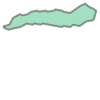

In [6]:
import shapely.wkt

P = shapely.wkt.loads(cat.metadata['geospatial_bounds'])
# P = shapely.wkt.loads(cats.source_cat['CBOFS'].metadata['geospatial_bounds'])
P

## Subset Spatially

### 1. Curvilinear, multiple horizontal grids

Subsetting in more complicated for this example case because it is a ROMS model that is both curvilinear and has multiple horizontal grids (such that different variables in the Dataset may have different associated horizontal grids).

#### Subset DataArray to box

Narrow only a single variable to the bounding box.

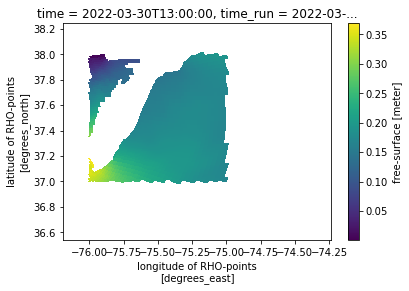

In [7]:
ds_cbofs['zeta'].em.sub_bbox(bbox=bbox_cbofs).cf.isel(T=0).cf.plot(x='longitude', y='latitude')

#### Subset Dataset to box

Narrow all variables in the Dataset to the bounding box.

In [8]:
ds_cbofs_ss = ds_cbofs.em.sub_bbox(bbox=bbox_cbofs)
ds_cbofs_ss

<xarray.Dataset>
Dimensions:         (tracer: 3, boundary: 4, s_rho: 20, s_w: 21, eta_rho: 124,
                     xi_rho: 151, eta_u: 124, xi_u: 150, eta_v: 123, xi_v: 149,
                     eta_psi: 123, xi_psi: 149, time: 240)
Coordinates: (12/20)
  * s_rho           (s_rho) float64 -0.975 -0.925 -0.875 ... -0.075 -0.025
  * s_w             (s_w) float64 -1.0 -0.95 -0.9 -0.85 ... -0.15 -0.1 -0.05 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(124, 151), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(124, 151), meta=np.ndarray>
  * xi_rho          (xi_rho) int64 181 182 183 184 185 ... 327 328 329 330 331
  * eta_rho         (eta_rho) int64 3 4 5 6 7 8 9 ... 121 122 123 124 125 126
    ...              ...
    lon_psi         (eta_psi, xi_psi) float64 dask.array<chunksize=(123, 149), meta=np.ndarray>
    lat_psi         (eta_psi, xi_psi) float64 dask.array<chunksize=(123, 149), meta=np.ndarray>
  * xi_psi          (xi_psi) int64 182 183 184 185 186 ... 326 327 328 329 330
  * eta_psi         (eta_psi) int64 3 4 5 6 7 8 9 ... 120 121 122 123 124 125
  * time            (time) datetime64[ns] 2022-03-30T13:00:00 ... 2022-04-09T...
    time_run        (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary
Data variables: (12/98)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    nHIS            int32 ...
    ...              ...
    salt            (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 20, 42, 22), meta=np.ndarray>
    oxygen          (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 20, 42, 22), meta=np.ndarray>
    Pair            (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 124, 151), meta=np.ndarray>
    Uwind           (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 124, 151), meta=np.ndarray>
    Vwind           (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 124, 151), meta=np.ndarray>
    time_offset     (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/42)
    file:                            nos.cbofs.fields.forecast.20220406.t12z_...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4
    type:                            ROMS/TOMS history file
    title:                           CBOFS - Chesapeake Bay Operational Forec...
    var_info:                        varinfo.dat
    ...                              ...
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:                   GRID
    featureType:                     GRID
    location:                        Proto fmrc:Aggregated_7_day_CBOFS_Fields...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               20

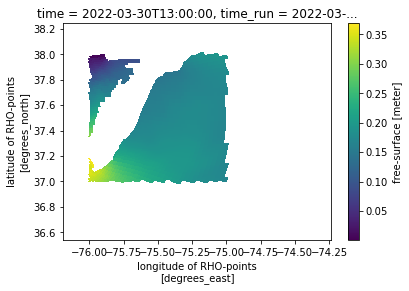

In [9]:
ds_cbofs_ss['zeta'].cf.isel(T=0).cf.plot(x='longitude', y='latitude')

#### Subset Dataset to proper set of grids

Return a Dataset with a full suite of horizontal grids of the proper relative sizes but narrowed to the bounding box. Because this model axes don't align with longitude and latitude, the shape of the result is different.

This function won't run with a DataArray.

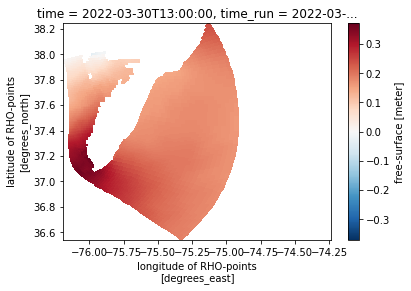

In [10]:
ds_cbofs_ss = ds_cbofs.em.sub_grid(bbox=bbox_cbofs)
ds_cbofs_ss['zeta'].cf.isel(T=0).cf.plot(x='longitude', y='latitude')

In [11]:
ds_cbofs_ss

<xarray.Dataset>
Dimensions:         (s_rho: 20, s_w: 21, eta_rho: 124, xi_rho: 151, eta_u: 124,
                     xi_u: 150, eta_v: 123, xi_v: 151, eta_psi: 123,
                     xi_psi: 150, time: 240, tracer: 3, boundary: 4)
Coordinates: (12/20)
  * s_rho           (s_rho) float64 -0.975 -0.925 -0.875 ... -0.075 -0.025
  * s_w             (s_w) float64 -1.0 -0.95 -0.9 -0.85 ... -0.15 -0.1 -0.05 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(124, 151), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(124, 151), meta=np.ndarray>
    lon_u           (eta_u, xi_u) float64 dask.array<chunksize=(124, 150), meta=np.ndarray>
    lat_u           (eta_u, xi_u) float64 dask.array<chunksize=(124, 150), meta=np.ndarray>
    ...              ...
  * xi_v            (xi_v) int64 181 182 183 184 185 186 ... 327 328 329 330 331
  * xi_psi          (xi_psi) int64 181 182 183 184 185 ... 326 327 328 329 330
  * eta_rho         (eta_rho) int64 3 4 5 6 7 8 9 ... 121 122 123 124 125 126
  * eta_u           (eta_u) int64 3 4 5 6 7 8 9 ... 120 121 122 123 124 125 126
  * eta_v           (eta_v) int64 3 4 5 6 7 8 9 ... 119 120 121 122 123 124 125
  * eta_psi         (eta_psi) int64 3 4 5 6 7 8 9 ... 120 121 122 123 124 125
Dimensions without coordinates: tracer, boundary
Data variables: (12/98)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    nHIS            int32 ...
    ...              ...
    salt            (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 20, 42, 22), meta=np.ndarray>
    oxygen          (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 20, 42, 22), meta=np.ndarray>
    Pair            (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 124, 151), meta=np.ndarray>
    Uwind           (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 124, 151), meta=np.ndarray>
    Vwind           (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 124, 151), meta=np.ndarray>
    time_offset     (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/42)
    file:                            nos.cbofs.fields.forecast.20220406.t12z_...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4
    type:                            ROMS/TOMS history file
    title:                           CBOFS - Chesapeake Bay Operational Forec...
    var_info:                        varinfo.dat
    ...                              ...
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:                   GRID
    featureType:                     GRID
    location:                        Proto fmrc:Aggregated_7_day_CBOFS_Fields...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               20

### 2. Rectilinear grid

#### Subset DataArray or Dataset to box (same as grid)

All of these have the same essential function when the grid is rectilinear. The only difference is whether operating on the full Dataset or a DataArray.

In [12]:
ds_cbofs_rg_ss = ds_cbofs_rg.em.sub_bbox(bbox=bbox_cbofs_rg)

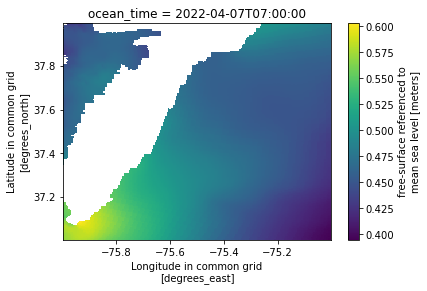

In [13]:
ds_cbofs_rg_ss['zeta'].cf.isel(T=0).cf.plot(x='longitude', y='latitude')

### 3. Curvilinear, single horizontal grid

#### Subset DataArray or Dataset to box (same as grid)

All of these also have the same essential function when there is only one horizontal grid. The only difference is whether operating on the full Dataset or a DataArray.

In [14]:
ds_loofs_ss = ds_loofs.em.sub_grid(bbox=bbox_loofs)
ds_loofs_ss

<xarray.Dataset>
Dimensions:      (time_1: 60, ny: 7, nx: 21, time: 252, sigma: 20)
Coordinates:
    lon          (ny, nx) float32 dask.array<chunksize=(7, 21), meta=np.ndarray>
    lat          (ny, nx) float32 dask.array<chunksize=(7, 21), meta=np.ndarray>
  * sigma        (sigma) float32 0.0 0.0227 0.0454 0.0681 ... 0.8853 0.9534 1.0
  * time         (time) datetime64[ns] 2022-03-30T12:59:45.938400 ... 2022-04-10
    time_run     (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * nx           (nx) int64 17 18 19 20 21 22 23 24 ... 30 31 32 33 34 35 36 37
  * ny           (ny) int64 8 9 10 11 12 13 14
Dimensions without coordinates: time_1
Data variables:
    validtime    (time_1, ny, nx) object dask.array<chunksize=(60, 7, 21), meta=np.ndarray>
    mask         (ny, nx) float32 dask.array<chunksize=(7, 21), meta=np.ndarray>
    depth        (ny, nx) float32 dask.array<chunksize=(7, 21), meta=np.ndarray>
    zeta         (time, ny, nx) float32 dask.array<chunksize=(1, 7, 21), meta=np.ndarray>
    air_u        (time, ny, nx) float32 dask.array<chunksize=(1, 7, 21), meta=np.ndarray>
    air_v        (time, ny, nx) float32 dask.array<chunksize=(1, 7, 21), meta=np.ndarray>
    u            (time, sigma, ny, nx) float32 dask.array<chunksize=(1, 20, 7, 21), meta=np.ndarray>
    v            (time, sigma, ny, nx) float32 dask.array<chunksize=(1, 20, 7, 21), meta=np.ndarray>
    temp         (time, sigma, ny, nx) float32 dask.array<chunksize=(1, 20, 7, 21), meta=np.ndarray>
    time_offset  (time, ny, nx) datetime64[ns] dask.array<chunksize=(1, 7, 21), meta=np.ndarray>
Attributes: (12/21)
    datum1:            reference to LWD=zeta
    datum2:            reference to IGLD85=zeta - IGLD85
    file_type:         Full_Grid
    Conventions:       CF-1.4
    grid_type:         rectilinear
    z_type:            2-D
    ...                ...
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:     GRID
    featureType:       GRID
    location:          Proto fmrc:Aggregated_7_day_LOOFS_Fields_Forecast
    DODS.strlen:       19
    DODS.dimName:      validtime_len

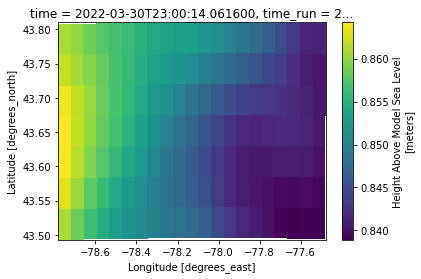

In [15]:
ds_loofs_ss['zeta'].cf.isel(T=10).cf.plot(x='longitude', y='latitude')

## Subset Temporally

Use `cf-xarray` to refer to the time dimension as `ds.cf['T']`.

### By time stamps

Use `ds.cf.sel(T=slice(start_time, end_time, stride))`.

In [16]:
ds_cbofs_rg_ss.cf['T'][:5]

<xarray.DataArray 'ocean_time' (ocean_time: 5)>
array(['2022-04-07T07:00:00.000000000', '2022-04-07T08:00:00.000000000',
       '2022-04-07T09:00:00.000000000', '2022-04-07T10:00:00.000000000',
       '2022-04-07T11:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2022-04-07T07:00:00 ... 2022-04-0...
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    standard_name:  time
    axis:           T

In [17]:
ds_cbofs_rg_ss.cf.sel(T=slice(start, start+pd.Timedelta('12 hours'), 3))

<xarray.Dataset>
Dimensions:      (ny: 199, nx: 199, ocean_time: 4, Depth: 15)
Coordinates:
    Latitude     (ny, nx) float64 dask.array<chunksize=(199, 199), meta=np.ndarray>
    Longitude    (ny, nx) float64 dask.array<chunksize=(199, 199), meta=np.ndarray>
  * nx           (nx) int64 269 270 271 272 273 274 ... 462 463 464 465 466 467
  * ny           (ny) int64 167 168 169 170 171 172 ... 360 361 362 363 364 365
  * ocean_time   (ocean_time) datetime64[ns] 2022-04-07T12:00:00 ... 2022-04-...
  * Depth        (Depth) float64 0.0 2.0 4.0 6.0 8.0 ... 35.0 40.0 45.0 50.0
Data variables:
    h            (ny, nx) float64 dask.array<chunksize=(199, 199), meta=np.ndarray>
    mask         (ny, nx) float64 dask.array<chunksize=(199, 199), meta=np.ndarray>
    zeta         (ocean_time, ny, nx) float32 dask.array<chunksize=(1, 199, 199), meta=np.ndarray>
    zetatomllw   (ocean_time, ny, nx) float32 dask.array<chunksize=(1, 199, 199), meta=np.ndarray>
    u_eastward   (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 15, 199, 50), meta=np.ndarray>
    v_northward  (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 15, 199, 50), meta=np.ndarray>
    temp         (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 15, 199, 50), meta=np.ndarray>
    salt         (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 15, 199, 50), meta=np.ndarray>
Attributes: (12/36)
    file:                            nos.cbofs.fields.nowcast.20220407.t12z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           cbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    tiling:                          010x014
    history:                         ROMS/TOMS, Version 3.9, Thursday - April...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ...
    bio_file:                        ROMS/Nonlinear/Biology/hypoxia_srm.h
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

### By time index

Use `ds.cf.isel(T=slice(start_index, end_index, stride))`.

In [18]:
ds_cbofs_rg_ss.cf.isel(T=slice(5, 15, 2))

<xarray.Dataset>
Dimensions:      (ny: 199, nx: 199, ocean_time: 5, Depth: 15)
Coordinates:
    Latitude     (ny, nx) float64 dask.array<chunksize=(199, 199), meta=np.ndarray>
    Longitude    (ny, nx) float64 dask.array<chunksize=(199, 199), meta=np.ndarray>
  * nx           (nx) int64 269 270 271 272 273 274 ... 462 463 464 465 466 467
  * ny           (ny) int64 167 168 169 170 171 172 ... 360 361 362 363 364 365
  * ocean_time   (ocean_time) datetime64[ns] 2022-04-07T12:00:00 ... 2022-04-...
  * Depth        (Depth) float64 0.0 2.0 4.0 6.0 8.0 ... 35.0 40.0 45.0 50.0
Data variables:
    h            (ny, nx) float64 dask.array<chunksize=(199, 199), meta=np.ndarray>
    mask         (ny, nx) float64 dask.array<chunksize=(199, 199), meta=np.ndarray>
    zeta         (ocean_time, ny, nx) float32 dask.array<chunksize=(1, 199, 199), meta=np.ndarray>
    zetatomllw   (ocean_time, ny, nx) float32 dask.array<chunksize=(1, 199, 199), meta=np.ndarray>
    u_eastward   (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 15, 199, 50), meta=np.ndarray>
    v_northward  (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 15, 199, 50), meta=np.ndarray>
    temp         (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 15, 199, 50), meta=np.ndarray>
    salt         (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 15, 199, 50), meta=np.ndarray>
Attributes: (12/36)
    file:                            nos.cbofs.fields.nowcast.20220407.t12z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           cbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    tiling:                          010x014
    history:                         ROMS/TOMS, Version 3.9, Thursday - April...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ...
    bio_file:                        ROMS/Nonlinear/Biology/hypoxia_srm.h
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

## Subset to Variables

Specify desired variables by standard names (in particular, those defined in the catalog files). The `filter()` method also retains the variables necessary to decode vertical coordinates in the future.

In [19]:
Vars = ['eastward_sea_water_velocity', 'northward_sea_water_velocity']
ds_cbofs_rg_ss.em.filter(Vars)

<xarray.Dataset>
Dimensions:      (ocean_time: 54, Depth: 15, ny: 199, nx: 199)
Coordinates:
    Latitude     (ny, nx) float64 dask.array<chunksize=(199, 199), meta=np.ndarray>
    Longitude    (ny, nx) float64 dask.array<chunksize=(199, 199), meta=np.ndarray>
  * nx           (nx) int64 269 270 271 272 273 274 ... 462 463 464 465 466 467
  * ny           (ny) int64 167 168 169 170 171 172 ... 360 361 362 363 364 365
  * ocean_time   (ocean_time) datetime64[ns] 2022-04-07T07:00:00 ... 2022-04-...
  * Depth        (Depth) float64 0.0 2.0 4.0 6.0 8.0 ... 35.0 40.0 45.0 50.0
Data variables:
    u_eastward   (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 15, 199, 50), meta=np.ndarray>
    v_northward  (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 15, 199, 50), meta=np.ndarray>
Attributes: (12/36)
    file:                            nos.cbofs.fields.nowcast.20220407.t12z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           cbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    tiling:                          010x014
    history:                         ROMS/TOMS, Version 3.9, Thursday - April...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ...
    bio_file:                        ROMS/Nonlinear/Biology/hypoxia_srm.h
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

## Return Dataset Size

`xarray` will estimate the size of the dataset with `.nbytes` — divide by 1e9 to get GB, or 1e6 to get MB instead.

In [20]:
ds_cbofs_rg_ss.em.filter(Vars).nbytes/1e6

257.251832

## Save to file

Save to file with `ds.to_netcdf([filename.nc])`.

## Put commands together

Select a few variables from the ROMS curvilinear grid model, then subset the Dataset in space to a smaller box, narrow the time range, check size, then save to file. Then, read in saved file to demonstrate that the vertical coordinates have been read in and calculated only at that point.

### 1. Curvilinear, multiple horizontal grids

In [21]:
%%time

standard_names = ['eastward_sea_water_velocity', 'northward_sea_water_velocity', 
        'sea_water_temperature', 'sea_water_practical_salinity', 'sea_floor_depth']

# Select bounding box for sub-domain
bbox = [-77, 38.5, -76, 40]

# Select time range to keep
today = pd.Timestamp.today()
yesterday = today - pd.Timedelta('1 day')

# Select out variables from Dataset
ds_small = ds_cbofs.em.filter(standard_names).em.sub_grid(bbox=bbox).cf.sel(T=slice(yesterday, today))

# Size of subset
print(f'Subdomain is {ds_small.nbytes/1e6} MB')

# Save to file
ds_small.to_netcdf('sample_roms.nc')

Subdomain is 342.343432 MB
CPU times: user 6.27 s, sys: 5.38 s, total: 11.6 s
Wall time: 2min 6s


Read in saved file with `extract_model` to get vertical coord decoding back in!

In [22]:
ds_small2 = xr.open_mfdataset(['sample_roms.nc'], preprocess=em.preprocess)
print(ds_small2.nbytes/1e6)
ds_small2

687.32596


<xarray.Dataset>
Dimensions:   (s_rho: 20, s_w: 21, eta_rho: 132, xi_rho: 332, time: 24,
               eta_u: 132, xi_u: 331, eta_v: 131, xi_v: 332)
Coordinates: (12/18)
  * s_rho     (s_rho) float64 -0.975 -0.925 -0.875 ... -0.125 -0.075 -0.025
  * s_w       (s_w) float64 -1.0 -0.95 -0.9 -0.85 -0.8 ... -0.15 -0.1 -0.05 0.0
    lon_rho   (eta_rho, xi_rho) float64 dask.array<chunksize=(132, 332), meta=np.ndarray>
    lat_rho   (eta_rho, xi_rho) float64 dask.array<chunksize=(132, 332), meta=np.ndarray>
  * time      (time) datetime64[ns] 2022-04-06T12:00:00 ... 2022-04-07T11:00:00
    time_run  (time) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    ...        ...
  * xi_u      (xi_u) int64 0 1 2 3 4 5 6 7 8 ... 323 324 325 326 327 328 329 330
  * xi_v      (xi_v) int64 0 1 2 3 4 5 6 7 8 ... 324 325 326 327 328 329 330 331
  * eta_u     (eta_u) int64 0 1 2 3 4 5 6 7 ... 124 125 126 127 128 129 130 131
  * eta_v     (eta_v) int64 0 1 2 3 4 5 6 7 ... 123 124 125 126 127 128 129 130
    z_w       (time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(24, 21, 132, 332), meta=np.ndarray>
    z_rho     (time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(24, 20, 132, 332), meta=np.ndarray>
Data variables:
    Cs_w      (s_w) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    hc        float64 ...
    h         (eta_rho, xi_rho) float64 dask.array<chunksize=(132, 332), meta=np.ndarray>
    zeta      (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 132, 332), meta=np.ndarray>
    Cs_r      (s_rho) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    u         (time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(24, 20, 132, 331), meta=np.ndarray>
    v         (time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(24, 20, 131, 332), meta=np.ndarray>
    temp      (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 20, 132, 332), meta=np.ndarray>
    salt      (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 20, 132, 332), meta=np.ndarray>
Attributes: (12/42)
    file:                            nos.cbofs.fields.forecast.20220406.t12z_...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4
    type:                            ROMS/TOMS history file
    title:                           CBOFS - Chesapeake Bay Operational Forec...
    var_info:                        varinfo.dat
    ...                              ...
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:                   GRID
    featureType:                     GRID
    location:                        Proto fmrc:Aggregated_7_day_CBOFS_Fields...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               20

In [23]:
ds_small2[['z_rho','z_w']].nbytes/1e6

345.688136

### 2. Rectilinear grid

In [24]:
%%time

standard_names = ['eastward_sea_water_velocity', 'northward_sea_water_velocity', 
        'sea_water_temperature', 'sea_water_practical_salinity', 'sea_floor_depth']

# Select bounding box for sub-domain
bbox = [-77, 38.5, -76, 40]

# Select time range to keep
today = pd.Timestamp.today()
tomorrow = today + pd.Timedelta('1 day')

# Select out variables from Dataset
ds_small_rg = ds_cbofs_rg.em.filter(standard_names).em.sub_grid(bbox=bbox).cf.sel(T=slice(today, tomorrow))

# Size of subset
print(f'Subdomain is {ds_small_rg.nbytes/1e6} MB')

# Save to file
ds_small_rg.to_netcdf('sample_roms_rg.nc')

Subdomain is 260.133328 MB
CPU times: user 19.4 s, sys: 16.2 s, total: 35.6 s
Wall time: 5min 23s


Read in saved file with `extract_model` to get vertical coord decoding back in!

In [25]:
ds_small_rg2 = xr.open_mfdataset(['sample_roms_rg.nc'], preprocess=em.preprocess)
print(ds_small_rg2.nbytes/1e6)
ds_small_rg2

260.133328


<xarray.Dataset>
Dimensions:      (ny: 226, nx: 199, ocean_time: 24, Depth: 15)
Coordinates:
  * Depth        (Depth) float64 0.0 2.0 4.0 6.0 8.0 ... 35.0 40.0 45.0 50.0
    Latitude     (ny, nx) float64 dask.array<chunksize=(226, 199), meta=np.ndarray>
    Longitude    (ny, nx) float64 dask.array<chunksize=(226, 199), meta=np.ndarray>
  * ocean_time   (ocean_time) datetime64[ns] 2022-04-07T12:00:00 ... 2022-04-...
  * nx           (nx) int64 69 70 71 72 73 74 75 ... 261 262 263 264 265 266 267
  * ny           (ny) int64 467 468 469 470 471 472 ... 687 688 689 690 691 692
Data variables:
    h            (ny, nx) float64 dask.array<chunksize=(226, 199), meta=np.ndarray>
    u_eastward   (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(24, 15, 226, 199), meta=np.ndarray>
    v_northward  (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(24, 15, 226, 199), meta=np.ndarray>
    temp         (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(24, 15, 226, 199), meta=np.ndarray>
    salt         (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(24, 15, 226, 199), meta=np.ndarray>
Attributes: (12/36)
    file:                            nos.cbofs.fields.nowcast.20220407.t12z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           cbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    tiling:                          010x014
    history:                         ROMS/TOMS, Version 3.9, Thursday - April...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ...
    bio_file:                        ROMS/Nonlinear/Biology/hypoxia_srm.h
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

### 3. Curvilinear, single horizontal grid

In [26]:
%%time

standard_names = ['eastward_sea_water_velocity', 'northward_sea_water_velocity', 
        'sea_water_temperature', 'sea_water_practical_salinity', 'sea_floor_depth']

# Select bounding box for sub-domain
bbox = [-78.8, 43.5, -77.5, 43.8]

# Select time range to keep
today = pd.Timestamp.today()
yesterday = today - pd.Timedelta('1 day')

# Select out variables from Dataset
ds_small_loofs = ds_loofs.em.filter(standard_names).em.sub_grid(bbox=bbox).cf.sel(T=slice(yesterday, today))

# Size of subset
print(f'Subdomain is {ds_small_loofs.nbytes/1e6} MB')

# Save to file
ds_small_loofs.to_netcdf('sample_loofs.nc')

Subdomain is 0.863284 MB
CPU times: user 734 ms, sys: 218 ms, total: 952 ms
Wall time: 10.6 s


Read in saved file with `extract_model` to get vertical coord decoding back in!

In [27]:
ds_small_loofs2 = xr.open_mfdataset(['sample_loofs.nc'], preprocess=em.preprocess)
print(ds_small_loofs2.nbytes/1e6)
ds_small_loofs2

1.145524


<xarray.Dataset>
Dimensions:   (time: 24, ny: 7, nx: 21, sigma: 20)
Coordinates:
  * sigma     (sigma) float32 0.0 0.0227 0.0454 0.0681 ... 0.8853 0.9534 1.0
    lon       (ny, nx) float32 dask.array<chunksize=(7, 21), meta=np.ndarray>
    lat       (ny, nx) float32 dask.array<chunksize=(7, 21), meta=np.ndarray>
  * time      (time) datetime64[ns] 2022-04-06T12:00:00 ... 2022-04-07T11:00:...
    time_run  (time) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
  * nx        (nx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * ny        (ny) int64 0 1 2 3 4 5 6
    z         (time, sigma, ny, nx) float32 dask.array<chunksize=(24, 20, 7, 21), meta=np.ndarray>
Data variables:
    zeta      (time, ny, nx) float32 dask.array<chunksize=(24, 7, 21), meta=np.ndarray>
    depth     (ny, nx) float32 dask.array<chunksize=(7, 21), meta=np.ndarray>
    u         (time, sigma, ny, nx) float32 dask.array<chunksize=(24, 20, 7, 21), meta=np.ndarray>
    v         (time, sigma, ny, nx) float32 dask.array<chunksize=(24, 20, 7, 21), meta=np.ndarray>
    temp      (time, sigma, ny, nx) float32 dask.array<chunksize=(24, 20, 7, 21), meta=np.ndarray>
Attributes: (12/21)
    datum1:            reference to LWD=zeta
    datum2:            reference to IGLD85=zeta - IGLD85
    file_type:         Full_Grid
    Conventions:       CF-1.4
    grid_type:         rectilinear
    z_type:            2-D
    ...                ...
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:     GRID
    featureType:       GRID
    location:          Proto fmrc:Aggregated_7_day_LOOFS_Fields_Forecast
    DODS.strlen:       19
    DODS.dimName:      validtime_len

In [28]:
ds_small_loofs2['z'].nbytes/1e6

0.28224